# Autoencoders

By Definition, an autoencoder is a neural network trained to downsize then reconstruct its input data from a latent representation. A convolutional autoencoder uses a CNN encoder to compress the input into the a latent representation and a deconvolutional (transposed convolution) decoder to reconstruct the input from the latent representation.

Optimization notes: 

- ensure images are stacked as a tensor instead of parsed in as a list of PIL images

In [1]:
import pickle, gzip, math, os, time, shutil, torch, matplotlib.pyplot as plt, numpy as np

In [2]:
import pandas as pd
import pathlib as Path
from torch.utils.data import DataLoader, default_collate
from typing import Mapping 
import datasets

/opt/anaconda3/envs/cv_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
with open('data/cifar-10-batches-py/data_batch_1', 'rb') as f:
    dataset_dict = pickle.load(f, encoding='bytes')

In [4]:
dataset_dict.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [5]:
dataset_dict[b'data'][0].shape

(3072,)

In [6]:
dataset_dict[b'batch_label']

b'training batch 1 of 5'

In [7]:
dataset_dict[b'labels'][0]

6

In [8]:
x_train = dataset_dict[b'data']
y_train = dataset_dict[b'labels']

In [9]:
x_train = torch.tensor(x_train, dtype=torch.float32).view(-1, 3, 32, 32)
y_train = torch.tensor(y_train, dtype=torch.long)

In [10]:
print(x_train.shape)
print(y_train.shape)

torch.Size([10000, 3, 32, 32])
torch.Size([10000])


In [11]:
# sample cnn
from torch import nn 

simple_cnn = nn.Sequential(
    nn.Conv2d(3, 4, kernel_size=3, stride=2, padding=1),    # 14x14x4
    nn.ReLU(),
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),    # 7x7x8
    nn.ReLU(),
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),    # 4x4x16
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),    # 2x2x16
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),    # 1x1x10
    nn.Flatten(),
)

simple_cnn(x_train[0].unsqueeze(0))

tensor([[-0.4463,  0.1121,  0.2813,  0.3727,  0.2054,  0.0144,  0.2675,  0.2481,
         -0.4389,  0.0106]], grad_fn=<ViewBackward0>)

In [28]:
X = x_train.reshape(10000, 3, 32, 32)

In [29]:
X.shape

torch.Size([10000, 3, 32, 32])

In [35]:
def show_torch_image(img):
    img = img.permute(1, 2, 0)
    img = img.numpy().astype(np.uint8)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

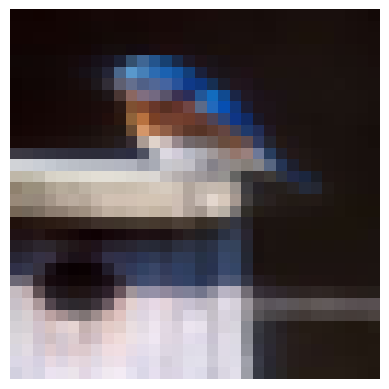

In [40]:
show_torch_image(X[13])

In [41]:
class ConvolutionalAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=3, stride=2, padding=1),    # 16x16x4
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),    # 8x8x8
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),    # 4x4x16
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),    # 2x2x16
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1),    # 4x4x16
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1),    # 8x8x8
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, kernel_size=3, stride=2, padding=1),    # 16x16x4
            nn.ReLU(),
            nn.ConvTranspose2d(4, 3, kernel_size=3, stride=2, padding=1),    # 32x32x3
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [42]:
def validate(model, loss_func, valid_dl):
    model.eval()
    with torch.no_grad():
        tot_loss,tot_acc,count = 0.,0.,0
        for xb,yb in valid_dl:
            pred = model(xb)
            n = len(xb)
            count += n
            tot_loss += loss_func(pred,yb).item()*n
    return tot_loss/count, tot_acc/count

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        validate(model, loss_func, valid_dl)

In [ ]:
from torch.utils.data import Dataset

class CIFARCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]